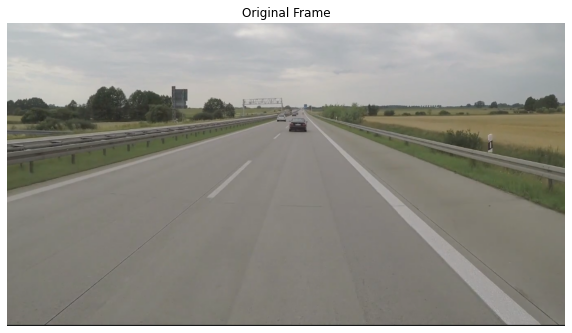

In [1]:
# Cell 1
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
frame = cv2.imread('data/t1.png')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  

# Display original frame
plt.figure(figsize=(10,6))
plt.imshow(frame)
plt.title('Original Frame')
plt.axis('off')
plt.show()


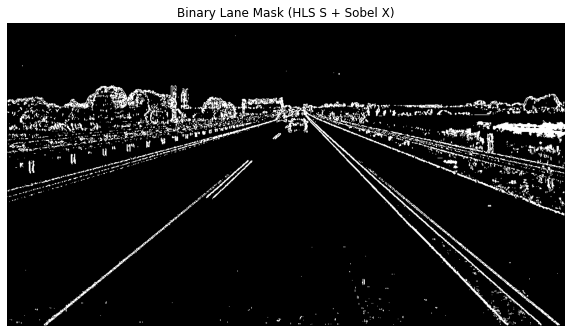

In [2]:

def preprocess_lane_mask(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    S = hls[:,:,2]

    # S channel threshold
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1

    # Sobel X on L channel
    sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=3)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Combine masks
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1

    return combined_binary


binary_mask = preprocess_lane_mask(frame, s_thresh=(60, 255), sx_thresh=(10, 120))

# Display
plt.figure(figsize=(10,6))
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Lane Mask (HLS S + Sobel X)')
plt.axis('off')
plt.show()


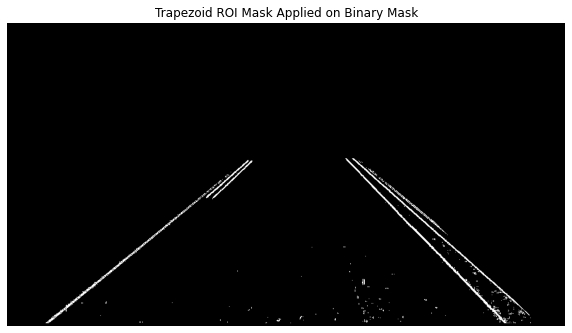

In [3]:
 
def apply_trapezoid_roi(binary_mask, roi_vertices):
  
    mask = np.zeros_like(binary_mask, dtype=np.uint8)
    cv2.fillPoly(mask, roi_vertices, 255)
 
    if binary_mask.max() == 1:
        binary_mask = (binary_mask * 255).astype(np.uint8)

    masked = cv2.bitwise_and(binary_mask, mask)
    return masked
 
h, w = binary_mask.shape[:2]
roi_vertices=np.array([[
        (w*0.07, h*0.99),    # bottom-left
        (w*0.4, h*0.45),       # top-left
        (w*0.65, h*0.45),       # top-right
        (w*0.95, h*0.99)      # bottom-right
    ]], dtype=np.int32)
roi_applied = apply_trapezoid_roi(binary_mask, roi_vertices)

plt.figure(figsize=(10,6))
plt.imshow(roi_applied, cmap='gray')
plt.title('Trapezoid ROI Mask Applied on Binary Mask')
plt.axis('off')
plt.show()
 

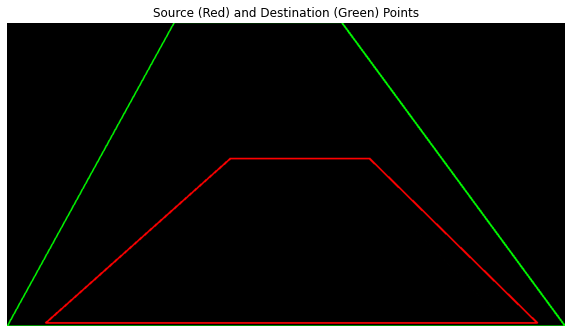

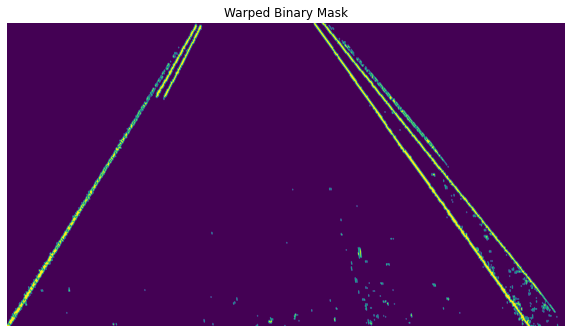

In [4]:

def draw_ipm_points(binary_img, src_points, dst_points):
    """
    Draw source trapezoid and destination rectangle on the binary mask.
    """
    h, w = binary_img.shape

    # Source points 
    src = src_points

    # Destination points (rectangle)
    dst = dst_points
 
    src_int = src.astype(int)
    dst_int = dst.astype(int)
 
    img_vis = cv2.cvtColor(binary_img*255, cv2.COLOR_GRAY2RGB)

    # Draw source trapezoid (red)
    cv2.polylines(img_vis, [src_int], isClosed=True, color=(255,0,0), thickness=2)

    # Draw destination rectangle (green)
    cv2.polylines(img_vis, [dst_int], isClosed=True, color=(0,255,0), thickness=2)
    #Perspective Transform:
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(binary_img, M, (w, h), flags=cv2.INTER_LINEAR)

    return img_vis,warped, M, Minv

h, w = roi_applied.shape
src = np.array([[
        (w*0.07, h*0.99),    # bottom-left
        (w*0.4, h*0.45),       # top-left
        (w*0.65, h*0.45),       # top-right
        (w*0.95, h*0.99)      # bottom-right
    ]], dtype=np.float32)

dst = np.float32([
    [0, h],   # bottom-left
    [w*0.3, 0],   # top-left
    [w*0.6, 0],   # top-right
    [w, h]    # bottom-right
])


# Draw IPM points
ipm_vis,warped_binary, M, Minv = draw_ipm_points(roi_applied, src, dst)

plt.figure(figsize=(10,6))
plt.imshow(ipm_vis)
plt.title("Source (Red) and Destination (Green) Points")
plt.axis('off')
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(warped_binary)
plt.title("Warped Binary Mask")
plt.axis('off')
plt.show()

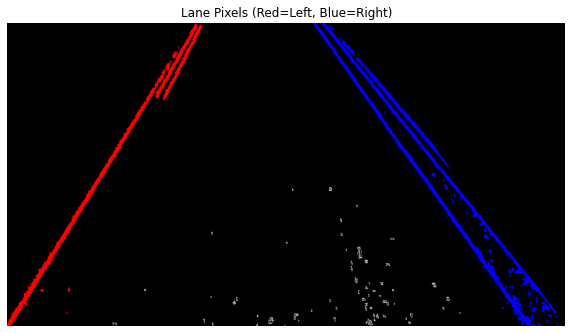

In [6]:
def find_lane_pixels(binary_warped, nwindows=2, margin=70, minpix=50):
    h, w = binary_warped.shape
    midpoint = w // 2

    # Separate left and right halves
    left_half = binary_warped[:, :midpoint]
    right_half = binary_warped[:, midpoint:]

    # Compute histograms
    left_hist = np.sum(left_half[h//2:, :], axis=0)
    right_hist = np.sum(right_half[h//2:, :], axis=0)

    leftx_base = np.argmax(left_hist)
    rightx_base = np.argmax(right_hist) + midpoint  # offset for right half

    # Sliding window setup
    window_height = h // nwindows
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = h - (window + 1) * window_height
        win_y_high = h - window * window_height

        # Left window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)

        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))

        # Right window
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        right_lane_inds.append(good_right_inds)

        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


# Apply half-image sliding window
leftx, lefty, rightx, righty = find_lane_pixels(warped_binary,nwindows=9, margin=100, minpix=50)

# Visualize lane pixels
out_img = np.dstack((warped_binary, warped_binary, warped_binary)) * 255
out_img[lefty, leftx] = [255, 0, 0]   # Red = left
out_img[righty, rightx] = [0, 0, 255] # Blue = right

plt.figure(figsize=(10, 6))
plt.imshow(out_img.astype(np.uint8))
plt.title('Lane Pixels (Red=Left, Blue=Right)')
plt.axis('off')
plt.show()


Left confidence: 1.00, Right confidence: 1.00


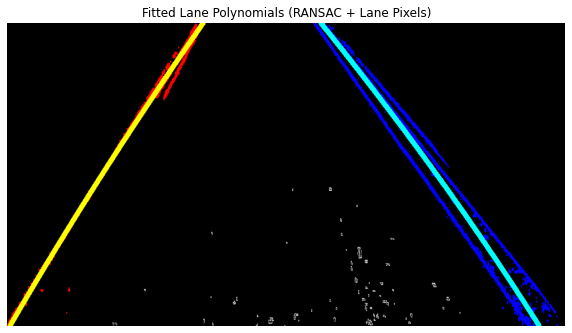

In [7]:
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fit_lane_polynomials(leftx, lefty, rightx, righty, min_pixels=500):
  
    left_fit = None
    right_fit = None

    # Confidence based on number of pixels
    left_conf = min(1.0, len(leftx)/min_pixels)
    right_conf = min(1.0, len(rightx)/min_pixels)

    # Left lane fit
    if len(leftx) > 0 and len(lefty) > 0:
        model_left = make_pipeline(PolynomialFeatures(2), RANSACRegressor())
        model_left.fit(lefty.reshape(-1,1), leftx)
        left_fit = model_left

    # Right lane fit
    if len(rightx) > 0 and len(righty) > 0:
        model_right = make_pipeline(PolynomialFeatures(2), RANSACRegressor())
        model_right.fit(righty.reshape(-1,1), rightx)
        right_fit = model_right

    return left_fit, right_fit, left_conf, right_conf


def draw_lane_fit(binary_img, left_fit, right_fit, leftx, lefty, rightx, righty, thickness=8):
   
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
    out_img = np.dstack((binary_img, binary_img, binary_img)) * 255

    # Overlay lane pixels
    out_img[lefty, leftx] = [255, 0, 0]   # red
    out_img[righty, rightx] = [0, 0, 255] # blue

    h, w = binary_img.shape

    # Left polynomial
    if left_fit is not None:
        left_fitx = left_fit.predict(ploty.reshape(-1,1))
        left_fitx = np.clip(left_fitx, 0, w-1)
        for i in range(len(ploty)-1):
            pt1 = (int(left_fitx[i]), int(ploty[i]))
            pt2 = (int(left_fitx[i+1]), int(ploty[i+1]))
            cv2.line(out_img, pt1, pt2, (255, 255, 0), thickness)  # yellow

    # Right polynomial
    if right_fit is not None:
        right_fitx = right_fit.predict(ploty.reshape(-1,1))
        right_fitx = np.clip(right_fitx, 0, w-1)
        for i in range(len(ploty)-1):
            pt1 = (int(right_fitx[i]), int(ploty[i]))
            pt2 = (int(right_fitx[i+1]), int(ploty[i+1]))
            cv2.line(out_img, pt1, pt2, (0, 255, 255), thickness)  # cyan

    return out_img
 

left_fit, right_fit, left_conf, right_conf = fit_lane_polynomials(leftx, lefty, rightx, righty)
print(f"Left confidence: {left_conf:.2f}, Right confidence: {right_conf:.2f}")

vis_img = draw_lane_fit(warped_binary, left_fit, right_fit, leftx, lefty, rightx, righty, thickness=8)

plt.figure(figsize=(10,6))
plt.imshow(vis_img.astype(np.uint8))
plt.title('Fitted Lane Polynomials (RANSAC + Lane Pixels)')
plt.axis('off')
plt.show()


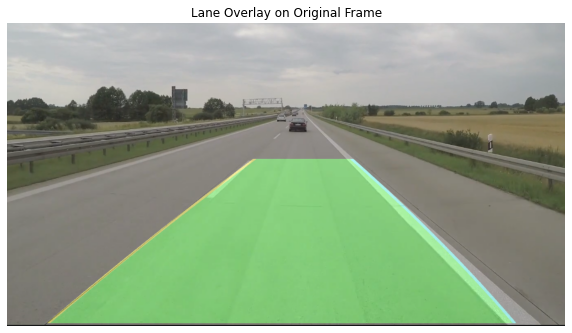

In [8]:
def draw_lane(original_img, warped_binary, left_fit_model, right_fit_model, Minv, line_thickness=5):
    
    h, w = warped_binary.shape
    ploty = np.linspace(0, h-1, h)
    color_warp = np.zeros((h, w, 3), dtype=np.uint8)

    # Only draw if both models exist
    if left_fit_model is not None and right_fit_model is not None:
        # Predict x values using RANSAC models
        left_fitx = left_fit_model.predict(ploty.reshape(-1,1))
        right_fitx = right_fit_model.predict(ploty.reshape(-1,1))

        # Clamp x values to image width
        left_fitx = np.clip(left_fitx, 0, w-1)
        right_fitx = np.clip(right_fitx, 0, w-1)

        # Create polygon points for lane fill
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Fill lane area (green) 
        cv2.fillPoly(color_warp, np.int32([pts]), (0, 255, 0))

        # Draw lane lines
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255, 255, 0), thickness=line_thickness)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0, 255, 255), thickness=line_thickness)

    # Warp back to original perspective
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h))
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)

    return result

 
lane_result = draw_lane(frame, warped_binary, left_fit, right_fit, Minv, line_thickness=5)

plt.figure(figsize=(10,6))
plt.imshow(lane_result)
plt.title('Lane Overlay on Original Frame')
plt.axis('off')
plt.show()


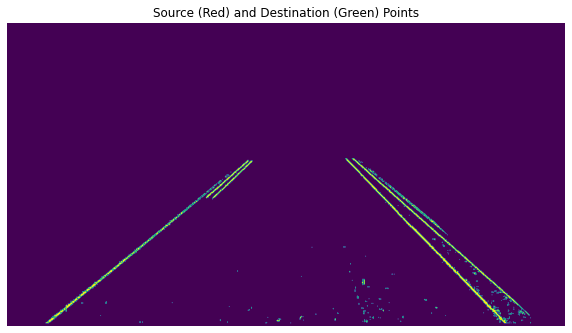

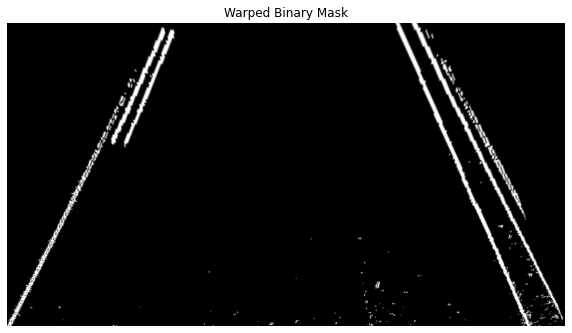

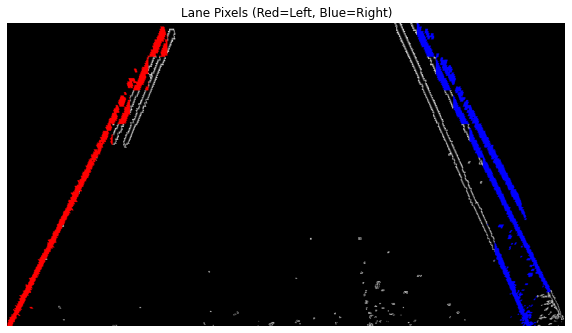

Left confidence: 1.00, Right confidence: 1.00


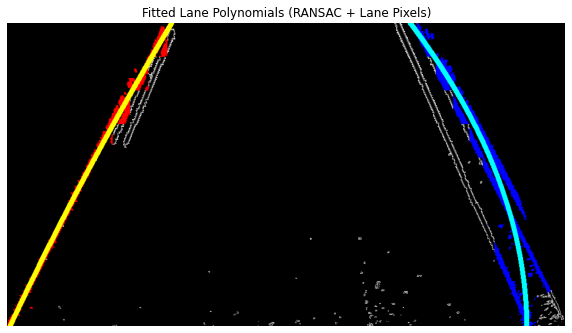

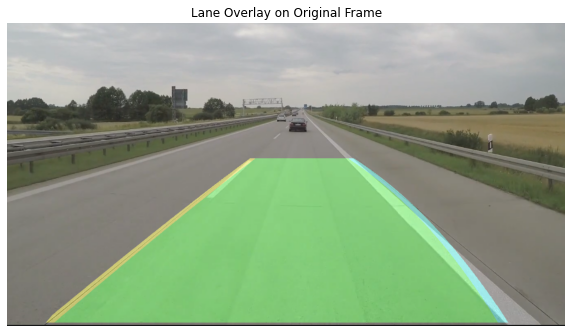

(array([[[193, 199, 200],
         [193, 199, 200],
         [193, 199, 200],
         ...,
         [164, 168, 172],
         [164, 168, 172],
         [164, 168, 172]],
 
        [[193, 199, 200],
         [193, 199, 200],
         [192, 199, 200],
         ...,
         [164, 169, 172],
         [164, 168, 172],
         [164, 168, 172]],
 
        [[193, 200, 200],
         [193, 199, 200],
         [193, 199, 200],
         ...,
         [165, 169, 173],
         [164, 168, 172],
         [164, 168, 172]],
 
        ...,
 
        [[117, 116, 109],
         [117, 115, 109],
         [117, 116, 109],
         ...,
         [125, 124, 115],
         [124, 123, 114],
         [123, 121, 112]],
 
        [[ 22,  23,  23],
         [ 22,  23,  23],
         [ 22,  23,  23],
         ...,
         [ 22,  23,  23],
         [ 22,  23,  23],
         [ 22,  23,  23]],
 
        [[ 22,  23,  23],
         [ 22,  23,  23],
         [ 22,  23,  23],
         ...,
         [ 22,  23,  23],
  

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def run_pipeline(image_path, roi_vertices=None, s_thresh=(60,255), sx_thresh=(10,120),
                 nwindows=9, margin=100, minpix=50, line_thickness=5):
    
    frame = cv2.imread(image_path)
    if frame is None:
        print(f" Could not read image: {image_path}")
        return
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = frame.shape[:2]
 

    # Preprocess to get binary mask
    binary_mask = preprocess_lane_mask(frame, s_thresh=s_thresh, sx_thresh=sx_thresh)
    # Apply ROI mask
    roi = apply_trapezoid_roi(binary_mask, roi_vertices)

    # Define IPM source and destination points
    src = roi_vertices.astype(np.float32).reshape(-1, 2)  # IPM source points
    dst = np.float32([
        [0, h],
        [w*0.2, 0],
        [w*0.8, 0],
        [w, h]
    ])

    # Draw IPM points and warp
    ipm_vis, warped_binary, M, Minv = draw_ipm_points(roi, src, dst)

    # Display IPM points and warped binary
    plt.figure(figsize=(10,6))
    plt.imshow(roi)
    plt.title("Source (Red) and Destination (Green) Points")
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.imshow(warped_binary, cmap='gray')
    plt.title("Warped Binary Mask")
    plt.axis('off')
    plt.show()

    # Find lane pixels
    leftx, lefty, rightx, righty = find_lane_pixels(warped_binary, nwindows=nwindows, margin=margin, minpix=minpix)

    # Visualize lane pixels
    out_img = np.dstack((warped_binary, warped_binary, warped_binary)) * 255
    out_img[lefty, leftx] = [255, 0, 0]   # Red = left
    out_img[righty, rightx] = [0, 0, 255] # Blue = right

    plt.figure(figsize=(10, 6))
    plt.imshow(out_img.astype(np.uint8))
    plt.title('Lane Pixels (Red=Left, Blue=Right)')
    plt.axis('off')
    plt.show()

    # Fit polynomials
    left_fit, right_fit, left_conf, right_conf = fit_lane_polynomials(leftx, lefty, rightx, righty)
    print(f"Left confidence: {left_conf:.2f}, Right confidence: {right_conf:.2f}")

    # Visualize fitted polynomials
    vis_img = draw_lane_fit(warped_binary, left_fit, right_fit, leftx, lefty, rightx, righty, thickness=8)
    plt.figure(figsize=(10,6))
    plt.imshow(vis_img.astype(np.uint8))
    plt.title('Fitted Lane Polynomials (RANSAC + Lane Pixels)')
    plt.axis('off')
    plt.show()

    # Draw lane on original image
    lane_result = draw_lane(frame, warped_binary, left_fit, right_fit, Minv, line_thickness=line_thickness)
    plt.figure(figsize=(10,6))
    plt.imshow(lane_result)
    plt.title('Lane Overlay on Original Frame')
    plt.axis('off')
    plt.show()

    return lane_result, left_fit, right_fit, left_conf, right_conf

h, w = frame.shape[:2]
# roi_vertices = np.array([[
#             [int(w*0.05), int(h*0.7)],
#             [int(w*0.35), int(h*0.5)],
#             [int(w*0.55), int(h*0.5)],
#             [int(w*0.95), int(h*0.7)]
#         ]], dtype=np.int32)
roi_vertices = np.array([[
        (w*0.07, h*0.99),    # bottom-left
        (w*0.4, h*0.45),       # top-left
        (w*0.65, h*0.45),       # top-right
        (w*0.95, h*0.99)      # bottom-right
    ]], dtype=np.int32)

dst = np.float32([
    [0, h],   # bottom-left
    [w*0.3, 0],   # top-left
    [w*0.6, 0],   # top-right
    [w, h]    # bottom-right
])

 
run_pipeline(
    image_path='data/t1.png',
    roi_vertices=roi_vertices,  # uses default trapezoid
    s_thresh=(60, 255),
    sx_thresh=(10, 120),
    nwindows=9,
    margin=50,
    minpix=50,
    line_thickness=20
)


## video

### Subtask:
Load the input video using OpenCV.


In [ ]:
 
def draw_polyline_with_confidence(img, fit_model, color, conf, is_left, thickness=8, dash=False):
   
    h, w = img.shape[:2]
    ploty = np.linspace(0, h-1, h)
    fitx = None

    if fit_model is not None:
        fitx = fit_model.predict(ploty.reshape(-1, 1))
        fitx = np.clip(fitx, 0, w-1)

        if conf >= 0.5:
            # Solid line
            pts = np.array([np.transpose(np.vstack([fitx, ploty]))], dtype=np.int32)
            cv2.polylines(img, pts, isClosed=False, color=color, thickness=thickness)
        else:
            # Dashed gray line
            dash_length = 30
            gap_length = 25
            for i in range(0, len(fitx)-1, dash_length + gap_length):
                start = int(i)
                end = int(min(i + dash_length, len(fitx)-1))
                cv2.line(img,
                         (int(fitx[start]), int(ploty[start])),
                         (int(fitx[end]), int(ploty[end])),
                         (160,160,160), thickness)
    else:
        # Fallback straight line on edge if no detection
        fitx = np.zeros_like(ploty) if is_left else np.full_like(ploty, w-1)
        for i in range(0, len(fitx)-1, 55):
            cv2.line(img, (int(fitx[i]), int(ploty[i])), (int(fitx[i+1]), int(ploty[i+1])), (160,160,160), thickness)

    return fitx, ploty


def draw_HUD(img, left_detected, right_detected, left_conf, right_conf, lat_offset_m=None, latency_ms=None):
  
    status_left = "YES" if left_detected else "NO"
    status_right = "YES" if right_detected else "NO"
    
     
    text1 = f"Left: {status_left} | Right: {status_right} | Conf: {left_conf:.2f}/{right_conf:.2f}"
    
   
    if lat_offset_m is not None:
        try:
            offset_val = float(lat_offset_m)
            offset_str = f"Offset: {offset_val:.3f}m"
        except (ValueError, TypeError):
            offset_str = "Offset: N/A"
    else:
        offset_str = "Offset: N/A"
    
    # Ensure latency is a valid number
    if latency_ms is not None:
        try:
            latency_val = float(latency_ms)
            latency_str = f"Latency: {latency_val:.1f}ms"
        except (ValueError, TypeError):
            latency_str = "Latency: N/A"
    else:
        latency_str = "Latency: N/A"
    
    text2 = f"{offset_str} | {latency_str}"
    
    org1 = (20, 38)
    org2 = (20, 78)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(img, (5,5), (850,100), (0,0,0), -1)  # black box back (taller for 2 lines)
    cv2.putText(img, text1, org1, font, 1.0, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(img, text2, org2, font, 0.9, (255,255,255), 2, cv2.LINE_AA)


def calculate_offset(left_fit, right_fit, img_shape):
     
    h, w = img_shape[:2]
    y_eval = h - 1
    xm_per_pix = 3.7 / (w * 0.6)   

    left_x = left_fit.predict([[y_eval]])[0] if left_fit is not None else None
    right_x = right_fit.predict([[y_eval]])[0] if right_fit is not None else None

    if left_x is not None and right_x is not None:
        lane_center = (left_x + right_x) / 2
        vehicle_center = w / 2
        offset_px = vehicle_center - lane_center
        offset_m = offset_px * xm_per_pix
        return offset_m
    return None


def fill_lane_area(img, left_fitx, right_fitx, ploty, color=(0, 255, 0), alpha=0.3):
    
    if left_fitx is None or right_fitx is None:
        return img

    h, w = img.shape[:2]
    color_warp = np.zeros_like(img, dtype=np.uint8)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int32([pts]), color)
    return cv2.addWeighted(img, 1, color_warp, alpha, 0)


def process_frame(frame, roi_vertices, s_thresh=(60,255), sx_thresh=(10,120),
                  dst_points=None, nwindows=9, margin=100, minpix=50, line_thickness=8,display=False):
    
    import time
    start_time = time.time()  
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = frame_rgb.shape[:2]

    src = roi_vertices.astype(np.float32).reshape(-1, 2)
    if dst_points is None:
        dst_points = np.float32([
            [0, h],
            [w*0.3, 0],
            [w*0.6, 0],
            [w, h]
        ])

    # Preprocess
    binary_mask = preprocess_lane_mask(frame_rgb, s_thresh=s_thresh, sx_thresh=sx_thresh)
    roi = apply_trapezoid_roi(binary_mask, roi_vertices)

    # IPM transform
    ipm_vis, warped_binary, M, Minv = draw_ipm_points(roi, src, dst_points)
    if display:
        plt.figure(figsize=(10,6))
        plt.imshow(roi)
        plt.title("Source (Red) and Destination (Green) Points")
        plt.axis('off')
        plt.show()

        
    # Sliding window lane detection
    leftx, lefty, rightx, righty = find_lane_pixels(warped_binary, nwindows=nwindows, margin=margin, minpix=minpix)
    left_fit, right_fit, left_conf, right_conf = fit_lane_polynomials(leftx, lefty, rightx, righty)
    left_detected = left_conf >= 0.5
    right_detected = right_conf >= 0.5

    # Draw lines and fill area
    lane_overlay = np.zeros_like(frame_rgb)
    left_fitx, ploty = draw_polyline_with_confidence(lane_overlay, left_fit, (0,255,0), left_conf, True, line_thickness)
    right_fitx, _ = draw_polyline_with_confidence(lane_overlay, right_fit, (0,128,255), right_conf, False, line_thickness)
    lane_overlay = fill_lane_area(lane_overlay, left_fitx, right_fitx, ploty)

    # Warp overlay back to original perspective
    newwarp = cv2.warpPerspective(lane_overlay, Minv, (w, h))
    result = cv2.addWeighted(frame_rgb, 1, newwarp, 0.6, 0)

    # Calculate offset and latency
    lat_offset_m = calculate_offset(left_fit, right_fit, frame_rgb.shape)
    latency_ms = (time.time() - start_time) * 1000  # Convert to milliseconds
    
    # Ensure latency is always a valid number (should be >= 0)
    if latency_ms is None or latency_ms < 0:
        latency_ms = 0.0
    
    # Draw HUD with offset and latency (values are recalculated each frame)
    draw_HUD(result, left_detected, right_detected, left_conf, right_conf, lat_offset_m, latency_ms)

    return result, left_detected, right_detected, left_conf, right_conf, lat_offset_m, latency_ms


In [23]:
%pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm 
import csv

def process_video_with_pipeline(input_path, output_path, roi_vertices,
                                s_thresh=(60,255), sx_thresh=(10,120),
                                dst_points=None,
                                nwindows=9, margin=100, minpix=50, line_thickness=8,
                                display=False,
                                csv_path=None):
    """
    Enhanced: process each frame, add HUD/text overlay, write CSV of lane results.
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Cannot open video file:", input_path)
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Use H.264 codec for browser compatibility (try 'avc1', fallback to 'mp4v' if not available)
    try:
        fourcc = cv2.VideoWriter_fourcc(*'avc1')  # H.264 codec (browser-compatible)
        out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))
        if not out.isOpened():
            raise Exception("avc1 codec not available")
    except:
        # Fallback to mp4v if H.264 is not available
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 codec (fallback)
        out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))
    print(f"Processing {total_frames} frames...")

    csv_records = []
    for frame_id in tqdm(range(total_frames)):
        ret, frame = cap.read()
        if not ret:
            break

        lane_result, left_detected, right_detected, left_conf, right_conf, lat_offset, latency_ms = process_frame(
            frame, roi_vertices, s_thresh=s_thresh, sx_thresh=sx_thresh, dst_points=dst_points, nwindows=nwindows,
            margin=margin, minpix=minpix, line_thickness=line_thickness,display=display)
        out.write(cv2.cvtColor(lane_result, cv2.COLOR_RGB2BGR))
        if display:
            import matplotlib.pyplot as plt
            plt.imshow(lane_result)
            plt.title(f'Frame {frame_id}')
            plt.axis('off')
            plt.show()
             
        csv_records.append([
            frame_id,
            int(left_detected),
            int(right_detected),
            round(float(left_conf), 4),
            round(float(right_conf), 4),
            round(float(lat_offset), 4) if lat_offset is not None else '',
            round(float(latency_ms), 2) if latency_ms is not None else ''
        ])

    cap.release()
    out.release()
    print(f" Done. Output saved to: {output_path}")

    # Calculate and print average latency
    if csv_records:
        latencies = [row[6] for row in csv_records if row[6] != '']
        if latencies:
            avg_latency = sum(latencies) / len(latencies)
            print(f"Average processing latency: {avg_latency:.2f} ms per frame")

    # Write CSV output
    if csv_path:
        with open(csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["frame_id","left_detected","right_detected","left_conf","right_conf","lat_offset_m","latency_ms"])
            for row in csv_records:
                writer.writerow(row)
        print(f"CSV with {len(csv_records)} rows saved to: {csv_path}")




In [ ]:
video_path = '/home/muhammad/My_Data/Semester3/Vehicles_n_Sensors/A1/data/t1_vid.mp4'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    raise ValueError("Cannot read the video file.")
h, w = frame.shape[:2]
cap.release()

# Define ROI and destination points for vedio
###############t1#########################
roi_vertices = np.array([[
    (w*0.07, h*0.99),   # bottom-left
    (w*0.5, h*0.58),   # top-left
    (w*0.55, h*0.58),   # top-right
    (w*0.95, h*0.99)    # bottom-right
]], dtype=np.int32)
#########################t2#########################
# roi_vertices = np.array([[
#     (-w-w*0.2, h*0.65),   # bottom-left
#     (w*0.2, h*0.22),   # top-left
#     (w*0.7, h*0.22),   # top-right
#     (w+0.2*w, h*0.65)    # bottom-right
# ]], dtype=np.int32)
dst_points = np.float32([
    [0, h],        # bottom-left
    [w*0.3, 0],    # top-left
    [w*0.6, 0],    # top-right
    [w, h]         # bottom-right
])

# Run pipeline and also output CSV for each frame
process_video_with_pipeline(
    input_path=video_path,
    output_path='/home/muhammad/My_Data/Semester3/Vehicles_n_Sensors/A1/results/t1_result.mp4',
    roi_vertices=roi_vertices,
    dst_points=dst_points,
    s_thresh=(60, 255),
    sx_thresh=(60, 100),
    nwindows=9,
    margin=100,
    minpix=50,
    line_thickness=16,  # thinner for better viewing
    display=False,  # set True to preview each frame
    csv_path='/home/muhammad/My_Data/Semester3/Vehicles_n_Sensors/A1/results/t1_results.csv'  # <-- NEW CSV OUTPUT
)


Processing 338 frames...


100%|██████████| 338/338 [00:44<00:00,  7.63it/s]

 Done. Output saved to: /home/muhammad/My_Data/Semester3/Vehicles_n_Sensors/A1/results/t1_result.mp4
Average processing latency: 108.92 ms per frame
CSV with 338 rows saved to: /home/muhammad/My_Data/Semester3/Vehicles_n_Sensors/A1/results/t1_results.csv
